Define some parameters and useful methods. Import libraries

In [134]:
%matplotlib inline
from pylab import *
import matplotlib.figure
import scipy.signal
import itertools
import random
import mpld3
mpld3.enable_notebook()

#set plot size and resolution
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90

#Play around with these values
nsymb = 8
bit_rate = 10
BT = 0.5
fc = 1e2
mod_index = 5
mod_sample_rate = 2e3
span = 2

def gauss_imp(BT, span, sample_rate):
    #num_coefficients is the sampling rate of the filter
    #3db_bandwidth is the 3db bandwidth of the gaussian filter
    #symbol time is the time difference between two symbols during transmission
    alph = np.sqrt(2. * np.pi / np.log(2)) * BT
    imp = np.linspace(- span * sample_rate / 2, span * sample_rate / 2, span*sample_rate)
    #generate coefficents
    imp *= np.sqrt(np.pi) * alph / sample_rate
    imp = - np.power(imp, 2)
    imp = np.exp(imp)
    imp *= alph
    imp /= sum(imp)
    return imp

def convolve(data, imp):
    out = []
    for a in range(len(data)):
        count = 0
        for i in range(len(imp)):
            if a - i >= 0:
                count += imp[i] * data[a - i]
        out.append(count)
    return np.array(out)

def periodic_data(num_symbols, num_samples):
    return  scipy.signal.square(
          np.linspace(0, num_symbols,
                      num_symbols * num_samples, endpoint=False)
          * np.pi)

def random_data(num_symbols, num_samples):
    arr = []
    for i in range(num_symbols):
        symb = random.randint(0, 1)
        for j in range(num_samples):
            arr.append(symb)
    return np.array(arr)

FSK method (no Gaussian Filtering), along with an example.

(-200.0, 200.0)

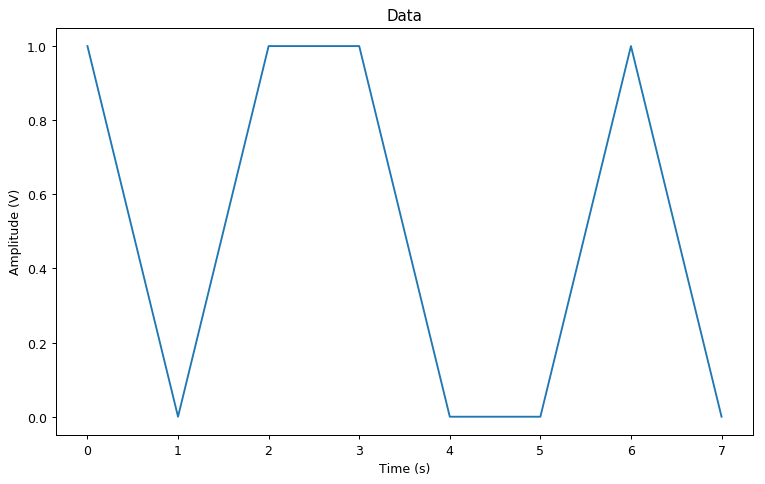

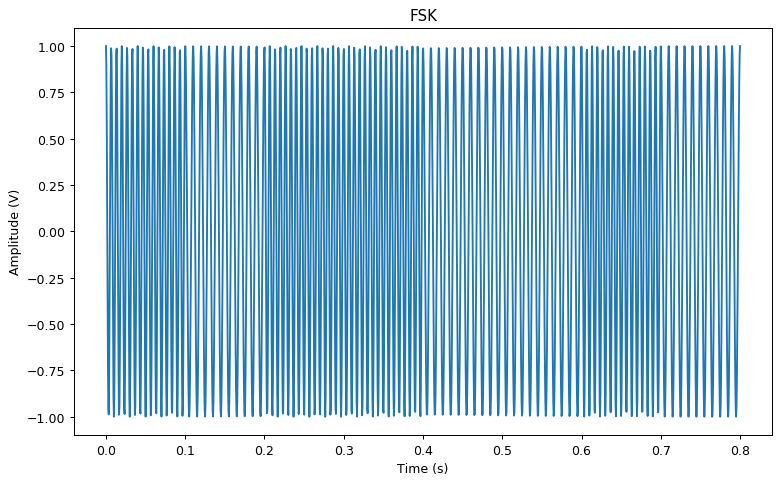

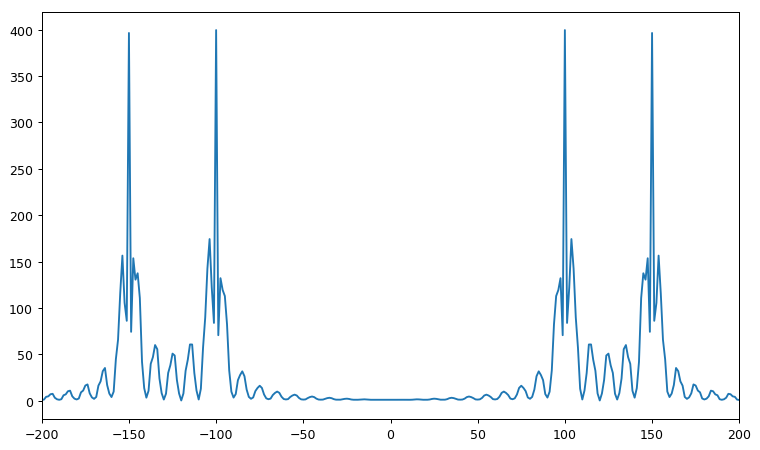

In [168]:
def FSK_mod(carrier_freq, freq_dev, mod_sample_rate, data, bit_rate):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    return time, np.cos(2 * np.pi * carrier_freq * time + 2 * np.pi * freq_dev * sampled_data * time)

data = random_data(nsymb, 1)
x, fsky = FSK_mod(fc, 50, mod_sample_rate, data, bit_rate)

plt.figure()
plt.plot(data)
plt.title('Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.figure()
plt.plot(x, fsky)
plt.title('FSK')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.figure()
fsk_fft = np.abs(np.fft.fftshift(np.fft.fft(fsky)))
fft_axis = np.fft.fftfreq(len(fsk_fft), 1./mod_sample_rate)
plt.plot(sorted(fft_axis), fsk_fft)
plt.xlim([-fc*2, fc*2])

GFSK method, along with an example.

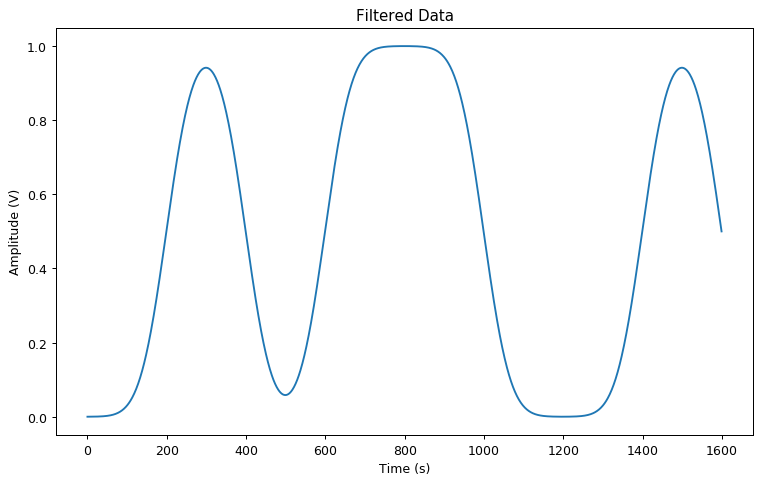

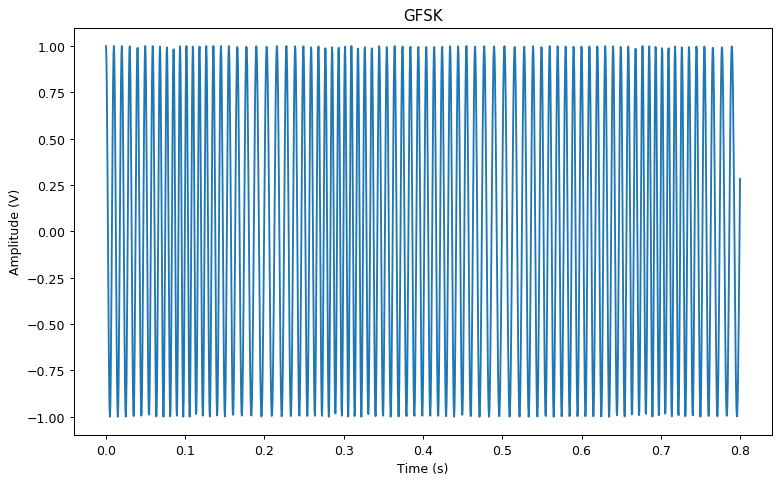

(-200.0, 200.0)

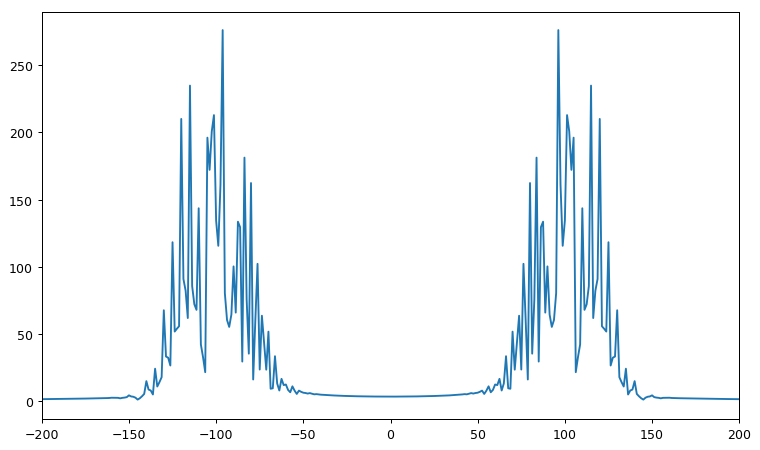

In [169]:
def GFSK_mod(carrier_freq, mod_index, mod_sample_rate, data, bit_rate, BT, span):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    imp = gauss_imp(BT, span, bit_span)
    
    filtered_data = convolve(sampled_data, imp)
    
    plt.figure()
    plt.plot(filtered_data)
    
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()
    
    return time, np.cos(2 * np.pi * carrier_freq * time + mod_index * filtered_data)

x, y = GFSK_mod(fc, 10, mod_sample_rate, data, bit_rate, BT, span)
plt.figure()
plt.plot(x, y)
plt.title('GFSK')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

plt.figure()
gfsk_fft = np.abs(np.fft.fftshift(np.fft.fft(y)))
fft_axis = np.fft.fftfreq(len(gfsk_fft), 1./mod_sample_rate)
plt.plot(sorted(fft_axis), gfsk_fft)
plt.xlim([-fc*2, fc*2])

Demodulation Filters. Using ideal Chebyshev designed with Remez's algorithm

In [170]:
demod_fir = scipy.signal.remez(72, [25, 35, 40, 60, 65, 75], [0, 1, 0], Hz=mod_sample_rate)
#plt.figure()
#plt.plot(demod_fir)
#freq, resp = scipy.signal.freqz(demod_fir)
#plt.figure()
#plt.plot(freq, np.abs(resp))

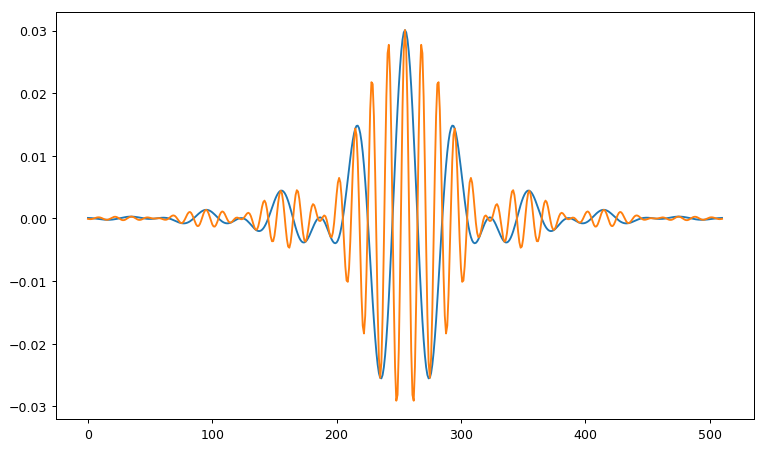

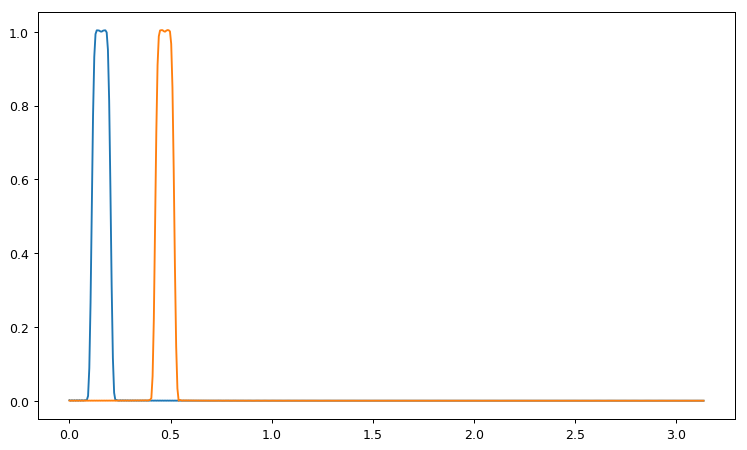

In [195]:
wind_fir_low = scipy.signal.firwin(511, [35.0 * 2/ mod_sample_rate, 65.0  * 2/ mod_sample_rate], pass_zero=False)
wind_fir_high = scipy.signal.firwin(511, [135.0  * 2/ mod_sample_rate, 165.0  * 2/ mod_sample_rate], pass_zero=False)
plt.figure()
plt.plot(wind_fir_low)
plt.plot(wind_fir_high)
freq_low, resp_low = scipy.signal.freqz(wind_fir_low)
freq_high, resp_high = scipy.signal.freqz(wind_fir_high)
plt.figure()
plt.plot(freq_low, np.abs(resp_low))
plt.plot(freq_high, np.abs(resp_high))

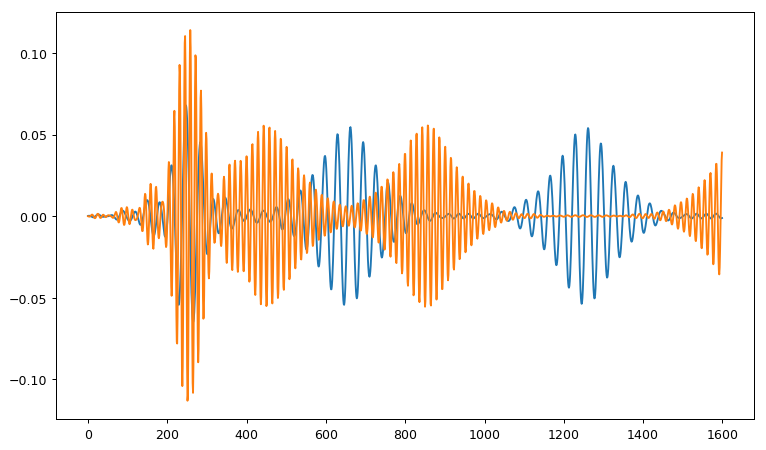

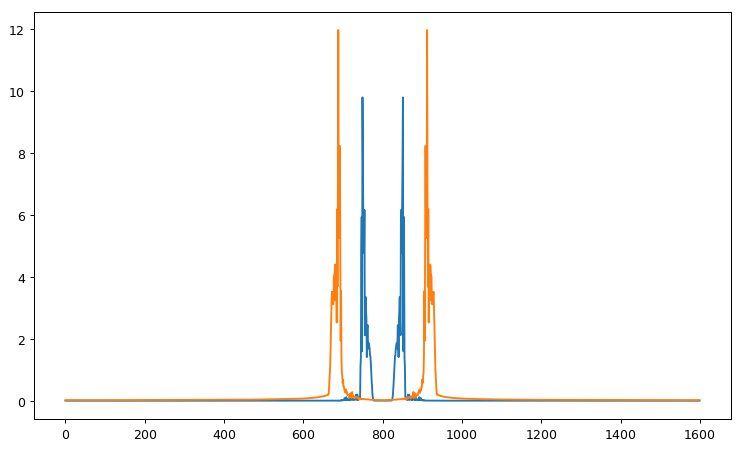

In [196]:
low_filtered = convolve(y, wind_fir_low)
high_filtered = convolve(y, wind_fir_high)
plt.figure()
plt.plot(low_filtered)
plt.plot(high_filtered)
plt.figure()
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(low_filtered))))
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(high_filtered))))

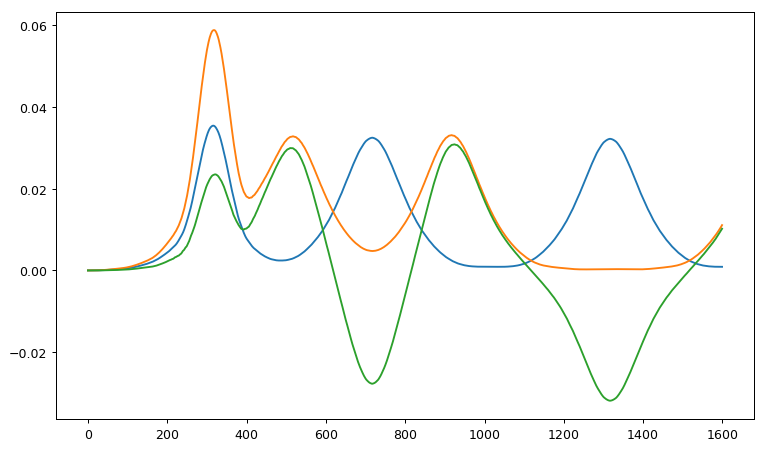

In [197]:
low_filtered = np.abs(low_filtered)
high_filtered = np.abs(high_filtered)
low_pass_coeff = scipy.signal.firwin(127, bit_rate / mod_sample_rate)
envelope_low = convolve(low_filtered, low_pass_coeff)
envelope_high = convolve(high_filtered, low_pass_coeff)
plt.figure()
plt.plot(envelope_low)
plt.plot(envelope_high)
plt.plot(envelope_high - envelope_low)

[1 1 1 0 1 1 0 1]


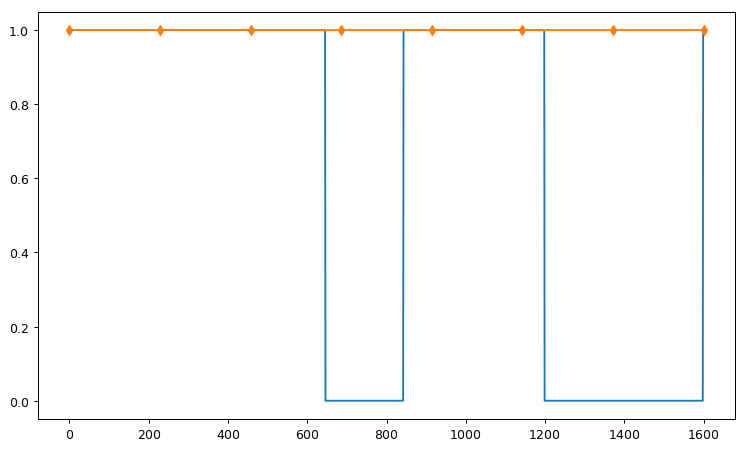

In [200]:
recovered_data = envelope_high - envelope_low
recovered_bits = [1]
for bit in (recovered_data):
    if recovered_bits[-1] == 1 and bit < -0.01:
        recovered_bits.append(0)
    elif recovered_bits[-1] == 0 and bit > 0.01:
        recovered_bits.append(1)
    else:
        recovered_bits.append(recovered_bits[-1])
plt.figure()
sampler = np.linspace(0, len(recovered_bits) - 1, len(recovered_bits)/mod_sample_rate * bit_rate)
recovered_bits = np.array(recovered_bits)
plt.plot(recovered_bits)
plt.plot(sampler, [1, 1, 1, 1, 1, 1, 1, 1], marker='d')
bits = recovered_bits[sampler.astype(int)]
print(bits)
        